In [1]:
using OrdinaryDiffEq
using Distributions
using Plots
using NLsolve

## Key Function Causing Strange Behavior

In [2]:
using ForwardDiff
using SpecialFunctions

mutable struct Bid{T1,T2,T3,T4}
    init_index::Int64
    a::T1
    b::T2
    q::T3
    a_over_q::T4
end


function quadprog_exactSolve(a,b,q, s, detail = false)
    num_bids = length(a)
    bidvec = [Bid(i, a[i],b[i],q[i],(a[i]/q[i])) for i=1:num_bids ]
    sorted_bids = sort(bidvec, by = x -> x.a_over_q, rev=true)
    
    if detail
        println("sorted_bids: ")
        for bid in sorted_bids
            println(bid)
        end
        
    end
    
    ## Save sorted vector for faster calculations
    sorted_a = [sorted_bids[i].a for i=1:num_bids]
    sorted_b = [sorted_bids[i].b for i=1:num_bids]
    sorted_q = [sorted_bids[i].q for i=1:num_bids]
    min_sorted_a_over_q = [-sorted_bids[i].a_over_q for i=1:num_bids]
    min_sorted_a_over_q_nxt = map(x->zero(float(x)), sorted_a)
#     @show min_sorted_a_over_q_nxt = [0.0 for i = 1:num_bids]
    
    for i=1:(num_bids-1)
        min_sorted_a_over_q_nxt[i] = min_sorted_a_over_q[i+1]
    end
    min_sorted_a_over_q_nxt[num_bids] = Inf


    ## Compute v_ks
    t1 = sorted_a .* sorted_q ./ sorted_b
    t2 = sorted_q.^2 ./ sorted_b
    t1_acc = accumulate(+, t1)
    t2_acc = accumulate(+, t2)
    
    ## Set v_ks and handle cases where b_i = 0
    xst_try = (2*s .- t1_acc) ./ t2_acc
    v_ks = copy(xst_try)
    v_ks = replace!(v_ks, NaN => Inf) 
    
    
    for i=1:(num_bids)
        v_ks[i] = sorted_b[i] <= 0 ? min_sorted_a_over_q[i] : min.(xst_try[i], min_sorted_a_over_q_nxt[i])
        if sorted_b[i] <= 0 ## only want to set the _first_ non-quad b
            break
        end
    end
    
    ## Compute duals
    function dual_eval(v)
#         x_stars = [0.0 for  i=1:num_bids]
#         x_stars = map(x->zero(float(x)), sorted_a)
        x_stars = map(x->zero(float(eltype(v))), 1:num_bids)
        dual_eval = 0.
        cum_qx = 0.
        for i=1:num_bids
            if min_sorted_a_over_q[i] > v
                break
            end
            if sorted_b[i] <= 0.
                x_stars[i] = (s-cum_qx)/sorted_q[i] 
                dual_eval += ( (sorted_a[i]/sorted_q[i]) + v ) * (s - cum_qx)
                break
            else
                x_stars[i] = ( (sorted_a[i] + (v * sorted_q[i]) ) / (2 * sorted_b[i]) )
                dual_eval += ( (sorted_a[i] + (v * sorted_q[i]) )^2 / (4 * sorted_b[i]) )
                cum_qx +=  sorted_q[i]*x_stars[i]
            end
        end

        out = dual_eval - v*s
        return(out, x_stars)
    end
    
    duals = [dual_eval(v_k) for v_k in v_ks]
    
    
    ## check corner solutions
    function getCornerObj(i)
        x_i_st = s ./ sorted_q[i]
        obj = sorted_a[i]*x_i_st - sorted_b[i]*(x_i_st^2)
        return((obj,i))
    end
    
    corner_vals = [getCornerObj(i) for i=1:num_bids]
    
    if detail
        println("v_ks: ", v_ks)
        println("dual obj: ", [duals[i][1] for i=1:length(duals)])
        println("corner obj: ", [corner_vals[i][1] for i=1:length(duals)])
    end

    
    sort!(duals, by = x -> x[1])
    sort!(corner_vals, by = x -> x[1], rev=true)

    duals_opt = duals[1]
    corners_opt = corner_vals[1]
    
    if duals_opt[1] >= corners_opt[1]
        opt_val = duals_opt[1]
        x_star_sorted = duals_opt[2]
    else
        opt_val = corners_opt[1]
        opt_i = corners_opt[2]
        x_star_sorted = map(x->zero(float(x)), sorted_a)
        x_star_sorted = x_star_sorted .+ 1e-8
        x_star_sorted[opt_i] = (s ./ sorted_q[opt_i])
    end
    x_star_orig_order = copy(x_star_sorted)
    for i = 1:num_bids
        bid = sorted_bids[i]
        x_star_orig_order[bid.init_index] = x_star_sorted[i]
    end
    
    return(x_star_orig_order)
    
end


quadprog_exactSolve (generic function with 2 methods)

## Other Functions

In [3]:
function getBoundarySMax(alpha_max, auc, q_b, q_e, sigma_sq)

    function ce_fun(svec)
        s_max_var = svec[1]
        out = getCE_riskaverse_scale(alpha_max, s_max_var, auc, q_b, q_e,sigma_sq)
        return out
    end

    lowest_score_seen = auc.q_e' * auc.c

    s_max_sol = nlsolve(ce_fun, [lowest_score_seen]; inplace = false)
    return s_max_sol.zero[1]

end

function getCE_riskaverse_scale(α, s, auc, q_b, q_e , sigma_sq)

    b_opt = getBidVector( s, α, auc, q_b, q_e, sigma_sq)
    b_min_c = b_opt - (α*auc.c);


    profit_ce = (q_b' * b_min_c) - ((auc.gamma) * 0.5 * ((sigma_sq .* b_min_c)' * b_min_c));

    return profit_ce
end

function getBidVector( s, α, auc, q_b, q_e, sigma_sq)
    # Compute the optimal unit bid vector for each score by solving the quadratic optimization problem

    b_tilde =  (auc.gamma * 0.5) * sigma_sq 
    a_tilde = (q_b + (auc.gamma * α * auc.c) .* sigma_sq)
    s_tilde = s
    q_tilde = q_e

    sol = quadprog_exactSolve(a_tilde,b_tilde,q_tilde,s_tilde)

    return sol

end

function getDbDsVec(s, α, auc, q_b, q_e, sigma_sq)
#     %Computes anayltical derivative of the optimal bid function of item t
#     % w.r.t. score s given alpha

    b_opt_of_s = x ->  getBidVector(x, α, auc, q_b, q_e, sigma_sq) 
    
    db_ds = ForwardDiff.derivative(b_opt_of_s, s)

    return(db_ds)

end


function ode_multi_item_w_risk_aversion( auc, α, s, qb, qo, sigma_sq)

    alpha_dist = LogNormal(auc.alpha_lgmean, auc.sigma_lgalpha)

    f(a) = pdf(alpha_dist, a);
    F(a) = cdf(alpha_dist, a);

    b_opt = getBidVector( s, α, auc, qb, qo, sigma_sq)
    db_ds = getDbDsVec(s, α, auc, qb, qo, sigma_sq)


    b_min_c = b_opt - (α*auc.c);

    profit_ce = (qb' * b_min_c) - ((auc.gamma) * 0.5 * ((sigma_sq .* b_min_c)' * b_min_c));

    profit_term = (exp(auc.gamma * (profit_ce)) - 1)

    numerator = (f(α) ./ (1 - F(α) - 0.000000001)) * (auc.num_bidders - 1);

    denominator = db_ds' * ((auc.gamma .* qb) - (auc.gamma^2 .* sigma_sq .* b_min_c) );
    numerator = numerator * profit_term;

    ds_dc = numerator / denominator; # Note: this should be a scalar

    return ds_dc

end


mutable struct Auction
    num_bidders::Int64
    T::Int64
    q_a::Vector{Float64}
    q_e::Vector{Float64}
    c::Vector{Float64}
    sigma_t_sq::Vector{Float64}
    gamma::Float64
    highest_alpha::Float64
    lowest_alpha::Float64
    alpha_lgmean::Float64
    sigma_lgalpha::Float64
end

## Working Example

In [4]:
s0 = 30.
qa0 = [12.; 40.; 30.];
qe0 = [10.; 50.; 40];
c0 = [5.;10.; 8];
sigmasq0 = [2.; 1.; 1.5];
γ0 = 0.05;

alpha_max = 2.0
alpha_min = 0.5
alpha_span = (alpha_max,alpha_min);

sample_auc = Auction(
    3,
    3,
    qa0,
    qe0,
    c0,
    sigmasq0,
    γ0,
    alpha_max,
    alpha_min,
    0,
    0.2
)

Auction(3, 3, [12.0, 40.0, 30.0], [10.0, 50.0, 40.0], [5.0, 10.0, 8.0], [2.0, 1.0, 1.5], 0.05, 2.0, 0.5, 0.0, 0.2)

s_max = getBoundarySMax(alpha_max, sample_auc, sample_auc.q_a, sample_auc.q_e, sample_auc.sigma_t_sq) = 1612.1541489353287


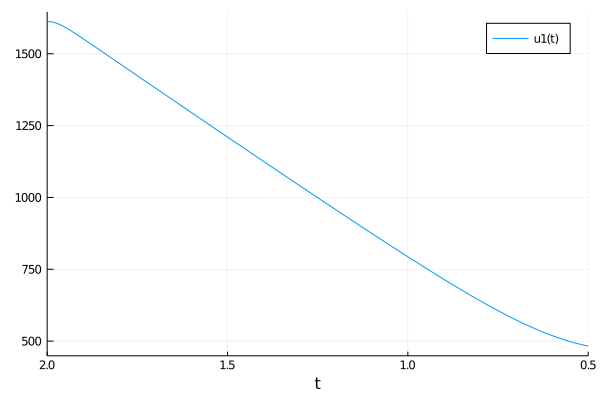

In [5]:
@show s_max = getBoundarySMax(alpha_max, sample_auc, sample_auc.q_a, sample_auc.q_e, sample_auc.sigma_t_sq)

ode_multi_item_w_risk_aversion_subs(s, p, α) = ode_multi_item_w_risk_aversion(sample_auc, α, s, sample_auc.q_a, sample_auc.q_e, sample_auc.sigma_t_sq)
eq_prob = ODEProblem(ode_multi_item_w_risk_aversion_subs, s_max, alpha_span)
eq_sol = OrdinaryDiffEq.solve(eq_prob, Rodas5())
plot(eq_sol)

## Breaking Example

In [7]:
zero_sigma_t_sq = sample_auc.sigma_t_sq .* 0.0 .+ 1e-3

@show zero_s_max = getBoundarySMax(alpha_max, sample_auc, sample_auc.q_a, sample_auc.q_e, zero_sigma_t_sq)

zero_ode_multi_item_w_risk_aversion_subs(s, p, α) = ode_multi_item_w_risk_aversion(sample_auc, α, s, sample_auc.q_a, sample_auc.q_e, zero_sigma_t_sq)
zero_eq_prob = ODEProblem(zero_ode_multi_item_w_risk_aversion_subs, s_max, alpha_span)
zero_eq_sol = OrdinaryDiffEq.solve(zero_eq_prob, Rodas5())
# plot(eq_sol)

zero_s_max = getBoundarySMax(alpha_max, sample_auc, sample_auc.q_a, sample_auc.q_e, zero_sigma_t_sq) = 1166.9174812732863


LoadError: MethodError: no method matching Float64(::ForwardDiff.Dual{ForwardDiff.Tag{var"#30#31"{Float64,Auction,Array{Float64,1},Array{Float64,1},Array{Float64,1}},Float64},Float64,1})
Closest candidates are:
  Float64(::Real, !Matched::RoundingMode) where T<:AbstractFloat at rounding.jl:200
  Float64(::T) where T<:Number at boot.jl:716
  Float64(!Matched::UInt16) at float.jl:66
  ...